In [13]:
cd '/content/drive/My Drive/Subjects/AIT 582 - Applications of Metadata in Complex Big Data Problems/Project'

/content/drive/My Drive/Subjects/AIT 582 - Applications of Metadata in Complex Big Data Problems/Project


In [2]:
import pandas as pd
import seaborn as sns, numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import math
ngFunctionsPresent = True
UNDEFINED_STR = "undefined"
UTMEasting = None
UTMNorthing = None
UTMZone = None     
zoneNumber = None
FOURTHPI    = math.pi / 4
DEG_2_RAD   = math.pi / 180
RAD_2_DEG   = 180.0 / math.pi
BLOCK_SIZE  = 100000
GRIDSQUARE_SET_COL_SIZE = 8   
GRIDSQUARE_SET_ROW_SIZE = 20
EASTING_OFFSET  = 500000.0
NORTHING_OFFSET = 10000000.0

In [0]:
k0 = 0.9996

EQUATORIAL_RADIUS = None
ECCENTRICTY_SQUARED = None
EQUATORIAL_RADIUS    = 6378137.0
ECC_SQUARED = 0.006694380023 
ECC_PRIME_SQUARED = ECC_SQUARED / (1 - ECC_SQUARED)
E1 = (1 - math.sqrt(1 - ECC_SQUARED)) / (1 + math.sqrt(1 - ECC_SQUARED))

In [0]:
def getZoneNumber(lat, lon):

	lat = float(lat)
	lon = float(lon)

	# sanity check on input
	#//////////////////////////////   /*
	#if lon > 360 or lon < -180 or lat > 90 or lat < -90:
	#	print "Bad input. lat: %s lon: %s" % (lat,lon)
	#//////////////////////////////  */

	# convert 0-360 to [-180 to 180] range
	lonTemp = (lon + 180) - int((lon + 180) / 360) * 360 - 180
	zoneNumber = int((lonTemp + 180) / 6) + 1

	# Handle special case of west coast of Norway
	if lat >= 56.0 and lat < 64.0 and lonTemp >= 3.0 and lonTemp < 12.0:
		zoneNumber = 32

	# Special zones for Svalbard
	if lat >= 72.0 and lat < 84.0:
		if lonTemp >= 0.0 and lonTemp < 9.0:
			zoneNumber = 31
		elif lonTemp >= 9.0 and lonTemp < 21.0:
			zoneNumber = 33
		elif lonTemp >= 21.0 and lonTemp < 33.0:
			zoneNumber = 35
		elif lonTemp >= 33.0 and lonTemp < 42.0:
			zoneNumber = 37

	return zoneNumber;  

In [0]:
def LLtoUTM_alt(lat,lon,utmcoords=None,zone=None):
	# utmcoords is a 2-D array declared by the calling routine
	lat = float(lat)
	lon = float(lon)

	# Constrain reporting USNG coords to the latitude range [80S .. 84N]
	#///////////////
	if (lat > 84.0 or lat < -80.0):
		return UNDEFINED_STR
	#////////////////////

	# sanity check on input - turned off when testing with Generic Viewer
	#///////////////////  /*
	#if lon > 360 or lon < -180 or lat > 90 or lat < -90:
	#	print "Bad input. lat: %s lon: %s" % (lat,lon)
	#////////////////////  */

	# Make sure the longitude is between -180.00 .. 179.99..
	# Convert values on 0-360 range to this range.
	lonTemp = (lon + 180) - int((lon + 180) / 360) * 360 - 180
	latRad = lat * DEG_2_RAD
	lonRad = lonTemp * DEG_2_RAD

	# user-supplied zone number will force coordinates to be computed in a particular zone
	zoneNumber = None
	if zone == None: 
		zoneNumber = getZoneNumber(lat, lon)
	else:
		zoneNumber = zone

	lonOrigin = (zoneNumber - 1) * 6 - 180 + 3  # +3 puts origin in middle of zone
	lonOriginRad = lonOrigin * DEG_2_RAD

	# compute the UTM Zone from the latitude and longitude
	UTMZone = "%s%s " % (zoneNumber,UTMLetterDesignator(lat))

	N = EQUATORIAL_RADIUS / math.sqrt(1 - ECC_SQUARED * math.sin(latRad) * math.sin(latRad))
	T = math.tan(latRad) * math.tan(latRad)
	C = ECC_PRIME_SQUARED * math.cos(latRad) * math.cos(latRad)
	A = math.cos(latRad) * (lonRad - lonOriginRad)

	# Note that the term Mo drops out of the "M" equation, because phi 
	# (latitude crossing the central meridian, lambda0, at the origin of the
	#  x,y coordinates), is equal to zero for UTM.
	M = EQUATORIAL_RADIUS * (( 1 - ECC_SQUARED / 4 - 3 * (ECC_SQUARED * ECC_SQUARED) / 64 - 5 * (ECC_SQUARED * ECC_SQUARED * ECC_SQUARED) / 256) * latRad - ( 3 * ECC_SQUARED / 8 + 3 * ECC_SQUARED * ECC_SQUARED / 32 + 45 * ECC_SQUARED * ECC_SQUARED * ECC_SQUARED / 1024) * math.sin(2 * latRad) + (15 * ECC_SQUARED * ECC_SQUARED / 256 + 45 * ECC_SQUARED * ECC_SQUARED * ECC_SQUARED / 1024) * math.sin(4 * latRad) - (35 * ECC_SQUARED * ECC_SQUARED * ECC_SQUARED / 3072) * math.sin(6 * latRad))

	UTMEasting = (k0 * N * (A + (1 - T + C) * (A * A * A) / 6 + (5 - 18 * T + T * T + 72 * C - 58 * ECC_PRIME_SQUARED ) * (A * A * A * A * A) / 120) + EASTING_OFFSET)

	UTMNorthing = (k0 * (M + N * math.tan(latRad) * ( (A * A) / 2 + (5 - T + 9 * C + 4 * C * C ) * (A * A * A * A) / 24 + (61 - 58 * T + T * T + 600 * C - 330 * ECC_PRIME_SQUARED ) * (A * A * A * A * A * A) / 720)))

	# added by LRM 2/08...not entirely sure this doesn't just move a bug somewhere else
	# utm values in southern hemisphere
	#  if (UTMNorthing < 0) {
	#	UTMNorthing += NORTHING_OFFSET;
	#  }

	utm = {}
	utm['e'] = UTMEasting
	utm['n'] = UTMNorthing
	utm['z'] = zoneNumber
	return "%s-%s-%s" % (UTMEasting, UTMNorthing, zoneNumber)
# end LLtoUTM


In [0]:
def LLtoUSNG(lat, lon, precision):

	lat = float(lat)
	lon = float(lon)

	# convert lat/lon to UTM coordinates
	ut = LLtoUTM_alt(lat, lon)
	utm = ut.split('-')
	try:
		UTMEasting = float(utm[0]) 
		UTMNorthing = float(utm[1])
		zoneNumber = utm[2]
	except IndexError:
		return ""

	# ...then convert UTM to USNG

	# southern hemispher case
	if lat < 0:
		# Use offset for southern hemisphere
		UTMNorthing = UTMNorthing + NORTHING_OFFSET

	USNGLetters  = findGridLetters(zoneNumber, UTMNorthing, UTMEasting)
	USNGNorthing = round(UTMNorthing) % BLOCK_SIZE
	USNGEasting  = round(UTMEasting)  % BLOCK_SIZE

	# added... truncate digits to achieve specified precision
	USNGNorthing = math.floor(USNGNorthing / math.pow(10,(5-precision)))
	USNGEasting = math.floor(USNGEasting / math.pow(10,(5-precision)))
	USNG = "%s%s %s " % (getZoneNumber(lat, lon),UTMLetterDesignator(lat),USNGLetters)

	# REVISIT: Modify to incorporate dynamic precision ?
	USNGEasting = ('%s' % int(USNGEasting)).zfill(precision)
	USNGNorthing = ('%s' % int(USNGNorthing)).zfill(precision)
	USNG = "%s %s %s" % (USNG, USNGEasting, USNGNorthing)

	return USNG
	# END LLtoUSNG() function


In [0]:
def UTMLetterDesignator(lat):
	lat = float(lat)

	if (84 >= lat) and (lat >= 72): 
		letterDesignator = 'X'
	elif (72 > lat) and (lat >= 64): 
		letterDesignator = 'W'
	elif (64 > lat) and (lat >= 56): 
		letterDesignator = 'V'
	elif (56 > lat) and (lat >= 48): 
		letterDesignator = 'U'
	elif (48 > lat) and (lat >= 40): 
		letterDesignator = 'T'
	elif (40 > lat) and (lat >= 32): 
		letterDesignator = 'S'
	elif (32 > lat) and (lat >= 24): 
		letterDesignator = 'R'
	elif (24 > lat) and (lat >= 16): 
		letterDesignator = 'Q'
	elif (16 > lat) and (lat >= 8):
		letterDesignator = 'P'
	elif ( 8 > lat) and (lat >= 0): 
		letterDesignator = 'N'
	elif ( 0 > lat) and (lat >= -8):
		letterDesignator = 'M'
	elif (-8> lat) and (lat >= -16): 
		letterDesignator = 'L'
	elif (-16 > lat) and (lat >= -24): 
		letterDesignator = 'K'
	elif (-24 > lat) and (lat >= -32): 
		letterDesignator = 'J'
	elif (-32 > lat) and (lat >= -40): 
		letterDesignator = 'H'
	elif (-40 > lat) and (lat >= -48): 
		letterDesignator = 'G'
	elif (-48 > lat) and (lat >= -56): 
		letterDesignator = 'F'
	elif (-56 > lat) and (lat >= -64): 
		letterDesignator = 'E'
	elif (-64 > lat) and (lat >= -72): 
		letterDesignator = 'D'
	elif (-72 > lat) and (lat >= -80): 
		letterDesignator = 'C'
	else: 
		letterDesignator = 'Z' # This is here as an error flag to show that the latitude is outside the UTM limits
	return letterDesignator
	# END UTMLetterDesignator() function

In [0]:
def findSet(zoneNum):
	zoneNum = int(zoneNum)
	zoneNum = zoneNum % 6

	if zoneNum == 0: 
		return 6
	elif zoneNum in range(1,6):
		return zoneNum
	else:
		return -1
	# END findSet() function

In [0]:
def findGridLetters(zoneNum, northing, easting):

	zoneNum  = int(zoneNum)
	northing = float(northing)
	easting  = float(easting)
	row = 1

	# northing coordinate to single-meter precision
	north_1m = round(northing)

	# Get the row position for the square identifier that contains the point
	while north_1m >= BLOCK_SIZE:
		north_1m = north_1m - BLOCK_SIZE
		row += 1

	# cycle repeats (wraps) after 20 rows
	row = row % GRIDSQUARE_SET_ROW_SIZE
	col = 0

	# easting coordinate to single-meter precision
	east_1m = round(easting)

	# Get the column position for the square identifier that contains the point
	while east_1m >= BLOCK_SIZE:
		east_1m = east_1m - BLOCK_SIZE
		col += 1

	# cycle repeats (wraps) after 8 columns
	col = col % GRIDSQUARE_SET_COL_SIZE

	return lettersHelper(findSet(zoneNum), row, col)
	# END findGridLetters() function 

In [0]:
def lettersHelper(set, row, col):

	# handle case of last row
	if row == 0:
		row = GRIDSQUARE_SET_ROW_SIZE - 1
	else:
		row -= 1

	# handle case of last column
	if col == 0:
		col = GRIDSQUARE_SET_COL_SIZE - 1
	else:
		col -=1     

	if set == 1:
		l1="ABCDEFGH"              # column ids
		l2="ABCDEFGHJKLMNPQRSTUV"  # row ids
		return l1[col] + l2[row]
	elif set == 2:
		l1="JKLMNPQR"
		l2="FGHJKLMNPQRSTUVABCDE"
		return l1[col] + l2[row]
	elif set == 3:
		l1="STUVWXYZ"
		l2="ABCDEFGHJKLMNPQRSTUV"
		return l1[col] + l2[row]
	elif set == 4:
		l1="ABCDEFGH"
		l2="FGHJKLMNPQRSTUVABCDE"
		return l1[col] + l2[row]
	elif set == 5:
		l1="JKLMNPQR"
		l2="ABCDEFGHJKLMNPQRSTUV"
		return l1[col] + l2[row]
	elif set == 6:
		l1="STUVWXYZ"
		l2="FGHJKLMNPQRSTUVABCDE"
		return l1[col] + l2[row]
	# END lettersHelper() function


In [0]:
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('output/processed_dataset_grids.csv')

In [47]:
df[df.State == 'NC'].groupby('County').size().sort_values(ascending=False)

County
Mecklenburg    17608
Wake           15127
Forsyth          490
Durham           465
Buncombe         405
               ...  
Hertford           2
Mitchell           2
Graham             2
Carteret           2
Pamlico            1
Length: 93, dtype: int64

In [0]:
county_of_states = ['Los Angeles', 'Harris', 'Greenville', 'Miami-Dade', 'Mecklenburg']

In [0]:
grids_county = []
for county in county_of_states:
  df_county = df[df.County==county]
  county_grid_freq = df_county.groupby('grid_1000m').size().sort_values(ascending=False)
  range_ = max(df_county.Start_Lat) - min(df_county.Start_Lat)
  xgrids = np.array([min(df_county.Start_Lat) + i * range_ / 100 for i in range(100)])
  range_ = max(df_county.Start_Lng) - min(df_county.Start_Lng)
  ygrids = np.array([min(df_county.Start_Lng) + i * range_ / 100 for i in range(100)])
  grids = np.zeros((100, 100)).tolist()
  for xidx, x in enumerate(xgrids):
    for yidx, y in enumerate(ygrids):
      if LLtoUSNG(x, y, 2) in county_grid_freq:
        grids[-xidx][-yidx] = county_grid_freq[LLtoUSNG(x, y, 2)]
  grids_county.append(grids)

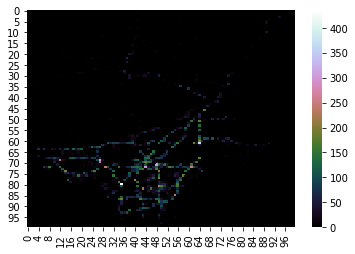

In [87]:
sns.heatmap(grids_county[0], cmap="cubehelix")

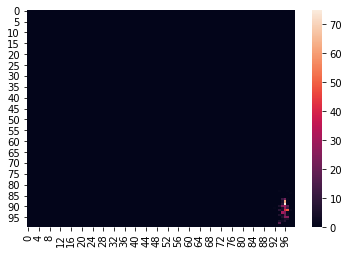

In [77]:
sns.heatmap(grids_county[1])

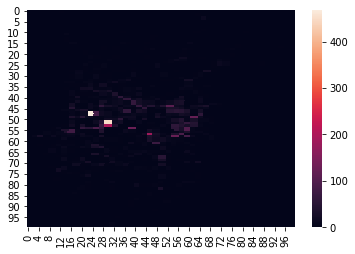

In [78]:
sns.heatmap(grids_county[2])

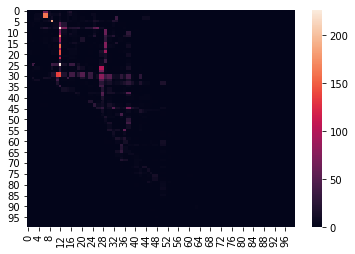

In [79]:
sns.heatmap(grids_county[3])

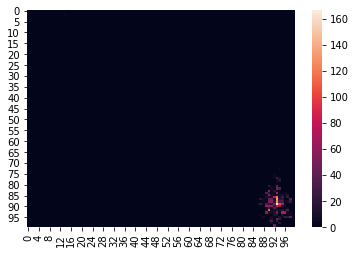

In [80]:
sns.heatmap(grids_county[4])